# ERA / OKID - AERSP597 (System ID) - Ani Perumalla

In [21]:
# Import necessary packages
import itertools as it # Readable nested for loops
from pathlib import Path # Filepaths
import typing # Argument / output type checking
import numpy as np # N-dim arrays + math
import scipy.linalg as spla # Complex linear algebra
import scipy.signal as spsg # Signal processing
import matplotlib.pyplot as plt # Plots
import matplotlib.figure as figure # Figure documentation

# Logistics
figs_dir = (Path.cwd() / "figs")
figs_dir.mkdir(parents = True, exist_ok = True)

In [22]:
def d2c(A: np.ndarray, B: np.ndarray,
        dt: float) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Convert discrete linear state space model to continuous linear state space model.

    :param np.ndarray A:
    :param np.ndarray B:
    :param float dt: Timestep duration
    :return: (A_c, B_c) Continuous-time linear state space model
    """
    A_c = spla.logm(A)/dt
    if np.linalg.cond(A - np.eye(*A.shape)) < 1/np.spacing(1):
        # print(f"Calculating continuous B via inversion.")
        B_c = A_c @ spla.inv(A - np.eye(*A.shape)) @ B
    else:
        # print(f"Calculating continuous B via sum.")
        B_temp = np.zeros(A_c.shape)
        for i in range(200):
            B_temp += (1/((i + 1)*np.math.factorial(i)))*np.linalg.matrix_power(A_c, i)*(dt**(i + 1))
        B_c = B @ spla.inv(B_temp)
    return A_c, B_c

def c2d(A_c: np.ndarray, B_c: np.ndarray,
        dt: float) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Convert continuous linear state space model to discrete linear state space model.

    :param np.ndarray A_c:
    :param np.ndarray B_c:
    :param float dt: Timestep duration
    :return: (A, B) Discrete-time linear state space model
    """
    A = spla.expm(A_c*dt)
    if np.linalg.cond(A_c) < 1/np.spacing(1):
        # print(f"Calculating discrete B via inversion.")
        B = (A - np.eye(*A.shape)) @ spla.inv(A_c) @ B_c
    else:
        # print(f"Calculating discrete B via sum.")
        B_temp = np.zeros(A_c.shape)
        for i in range(200):
            B_temp += (1/((i + 1)*np.math.factorial(i)))*np.linalg.matrix_power(A_c, i)*(dt**(i + 1))
        B = B_temp @ B_c
    return A, B

def sim_ss(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray,
           X_0: np.ndarray, U: np.ndarray,
           nt: int) \
        -> typing.Tuple[np.ndarray, np.ndarray]:
    """Simulate linear state space model via ZOH.

    :param np.ndarray A:
    :param np.ndarray B:
    :param np.ndarray C:
    :param np.ndarray D:
    :param np.ndarray X_0: Initial state condition
    :param np.ndarray U: Inputs, either impulse or continual
    :param nt: Number of timesteps to simulate
    :return: (X) State vector array over duration; (Z) Observation vector array over duration
    """
    assert D.shape == (C @ A @ B).shape
    assert X_0.shape[-2] == A.shape[-1]
    assert U.shape[-2] == B.shape[-1]
    assert A.shape[-2] == B.shape[-2]
    assert C.shape[-2] == D.shape[-2]
    assert A.shape[-1] == C.shape[-1]
    assert B.shape[-1] == D.shape[-1]
    assert (U.shape[-1] == 1) or (U.shape[-1] == nt) or (U.shape[-1] == nt - 1)

    X = np.concatenate([X_0, np.zeros([X_0.shape[-2], nt])], 1)
    Z = np.zeros([C.shape[-2], nt])
    if U.shape[-1] == 1: # Impulse
        X[:, 1] = (A @ X[:, 0]) + (B @ U[:, 0])
        Z[:, 0] = (C @ X[:, 0]) + (D @ U[:, 0])
        for i in range(1, nt):
            X[:, i + 1] = (A @ X[:, i])
            Z[:, i] = (C @ X[:, i])
    else: # Continual
        for i in range(0, nt):
            X[:, i + 1] = (A @ X[:, i]) + (B @ U[:, i])
            Z[:, i] = (C @ X[:, i]) + (D @ U[:, i])
    return X, Z

def markov_sim(Y: np.ndarray, U: np.ndarray) \
        -> np.ndarray:
    """Obtain observations from Markov parameters and inputs, for zero initial conditions

    :param np.ndarray Y: Markov parameter matrix
    :param np.ndarray U: Continual inputs
    :return: (Z) Observation vector array over duration
    :rtype: np.ndarray
    """
    l, m, r = Y.shape
    Y_2_Z = np.zeros([r*l, l])
    Y_2_Z[:r, :] = U
    for i in range(1, l):
        Y_2_Z[r*i:r*(i + 1), :] = np.concatenate([np.zeros([r, i]), U[:, 0:(-i)]], 1)
    Z = np.concatenate(Y, 1) @ Y_2_Z
    return Z

def ss2markov(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray,
              nt: int) \
        -> np.ndarray:
    """Get Markov parameters from state space model.

    :param np.ndarray A:
    :param np.ndarray B:
    :param np.ndarray C:
    :param np.ndarray D:
    :param nt: Number of Markov parameters to generate (i.e., length of simulation)
    :return: (Y) 3D array of Markov parameters
    :rtype: np.ndarray
    """
    assert D.shape == (C @ A @ B).shape
    Y = np.zeros([nt, *D.shape])
    Y[0] = D
    for i in range(1, nt):
        Y[i] = C @ (np.linalg.matrix_power(A, i - 1)) @ B
    return Y

def Hankel(Y: np.ndarray, alpha: int, beta: int, i: int = 0) \
        -> np.ndarray:
    """Hankel matrix.

    :param Y: Markov parameter matrix
    :param alpha: Num. of rows of Markov parameters in Hankel matrix
    :param beta: Num. of columns of Markov parameters in Hankel matrix
    :param i: Start node of Hankel matrix
    :return: Block Hankel matrix.
    :rtype: np.ndarray
    """
    assert (len(Y) - 1) >= (i + alpha + beta - 1)
    m, r = Y.shape[-2:]
    H = np.zeros([alpha*m, beta*r])
    for j in range(beta):
        H[:, (j*r):((j + 1)*r)] = Y[(i + 1 + j):(i + alpha + 1 + j)].reshape([alpha*m, r])
    return H

def era(Y: np.ndarray, alpha: int, beta: int, n: int) \
        -> typing.Tuple[np.ndarray,
                        np.ndarray,
                        np.ndarray,
                        np.ndarray,
                        np.ndarray]:
    """Eigensystem Realization Algorithm (ERA).

    :param np.ndarray Y: Markov parameter matrix
    :param int alpha: Num. of rows of Markov parameters in Hankel matrix
    :param int beta: Num. of columns of Markov parameters in Hankel matrix
    :param int n: Order of proposed linear state space system
    :returns: (A, B, C, D) - State space of proposed linear state space system; (S) - Singular Values of H(0)
    :rtype: (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray)
    """
    assert (len(Y) - 1) >= (alpha + beta - 1)
    m, r = Y.shape[-2:]
    H_0 = Hankel(Y, alpha, beta, 0)
    print(f"Dimensions of H(0): {H_0.shape}")
    print(f"Rank of H(0): {np.linalg.matrix_rank(H_0)}")
    H_1 = Hankel(Y, alpha, beta, 1)
    print(f"Rank of H(1): {np.linalg.matrix_rank(H_1)}")
    U_sim, S, Vh = np.linalg.svd(H_0)
    print(f"Singular Values of H(0): {S}")
    V = Vh.T
    U_n = U_sim[:, :n]
    V_n = V[:, :n]
    S_n = S[:n]

    E_r = np.concatenate([np.eye(r), np.tile(np.zeros([r, r]), beta - 1)], 1).T
    E_m = np.concatenate([np.eye(m), np.tile(np.zeros([m, m]), alpha - 1)], 1).T
    A = np.diag(S_n**(-1/2)) @ U_n.T @ H_1 @ V_n @ np.diag(S_n**(-1/2))
    B = np.diag(S_n**(1/2)) @ V_n.T @ E_r
    C = E_m.T @ U_n @ np.diag(S_n**(1/2))
    D = Y[0]
    return A, B, C, D, S

def okid(Z: np.ndarray, U: np.ndarray,
         l_0: int,
         alpha: int, beta: int,
         n: int) \
        -> typing.Tuple[np.ndarray, np.ndarray,
                        np.ndarray, np.ndarray, np.ndarray]:
        # -> np.ndarray:
    """Observer Kalman Identification Algorithm (OKID).

    :param np.ndarray Z: Observation vector array over duration
    :param np.ndarray U: Continual inputs
    :param int l_0: Order of OKID to execute (i.e., number of Markov parameters to generate via OKID)
    :param int alpha: Num. of rows of Markov parameters in Hankel matrix
    :param int beta: Num. of columns of Markov parameters in Hankel matrix
    :param int n: Number of proposed states to use for ERA
    :return: (Y) Markov parameters
    :rtype: np.ndarray
    """
    r, l_u = U.shape
    m, l  = Z.shape
    assert l == l_u
    V = np.concatenate([U, Z], 0)
    assert (max([alpha + beta, (n/m) + (n/r)]) <= l_0) and (l_0 <= (l - r)/(r + m)) # Boundary conditions

    # Form observer
    Y_2_Z = np.zeros([r + (r + m)*l_0, l])
    Y_2_Z[:r, :] = U
    for i in range(1, l_0 + 1):
        Y_2_Z[((i*r) + ((i - 1)*m)):(((i + 1)*r) + (i*m)), :] = np.concatenate([np.zeros([r + m, i]), V[:, 0:(-i)]], 1)
    # Find Observer Markov parameters via least-squares
    Y_obs = Z @ spla.pinv2(Y_2_Z)
    Y_bar_1 = np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + r)]
                                                    for i in range(r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, r])
    Y_bar_2 = -np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + m)]
                                                     for i in range(2*r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, m])

    # Obtain Markov parameters from Observer Markov parameters
    Y = np.zeros([l_0 + 1, m, r])
    Y[0] = Y_obs[:, :r]
    for k in range(1, l_0 + 1):
        # print(np.array([Y_bar_2[i - 1] @ Y[k - i] for i in range(k)]).squeeze(-1).T.shape)
        # print(f"{k=}")
        # print(f"{Y_bar_1[k]=}")
        # print(f"{Y_bar_1[k].shape=}")
        # print(np.array([Y_bar_2[i - 1] @ Y[k - i] for i in range(k)]))
        # print(np.array([Y_bar_2[i - 1] @ Y[k - i] for i in range(k)]).sum(axis = 0))
        # Y[k] = Y_bar_1[k] - sum([Y_bar_2[i - 1] @ Y[k - i] for i in range(k)], 1)
        Y[k] = Y_bar_1[k - 1] - \
               np.array([Y_bar_2[i] @ Y[k - (i + 1)]
                         for i in range(k)]).sum(axis = 0)
    # for k in range(l_0 + 1, l):
    #     Y[k] = -np.array([Y_bar_2[i] @ Y[k - (i + 1)]
    #                       for i in range(l_0)]).sum(axis = 0)
        # Y[k] = -sum([Y_bar_2[i - 1] @ Y[k - i] for i in range(l_0)])
    return Y, Y_2_Z, Y_obs, Y_bar_1, Y_bar_2

In [23]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt_sim = 0.1 # Simulation timestep duration
nt_sim = int(t_max/dt_sim) # Number of simulation timesteps
dt_sample = 0.1 # Sample timestep duration
nt_sample = int(t_max/dt_sample) # Number of sample timesteps
interval = int(dt_sample/dt_sim) # Sample index interval

# Simulation time
train_cutoff = int(20/dt_sample) + 1
t_sim = np.linspace(0, t_max, nt_sim + 1)
t_sample = np.linspace(0, t_max, nt_sample + 1)
t_train = t_sample[:train_cutoff]
# t_test_1 = t_sample[train_cutoff:]
# t_test_23 = t_sample
t_test = t_sample
nt_train = train_cutoff
# nt_test_1 = nt_sample - train_cutoff
# nt_test_23 = nt_sample
nt_test = nt_sample

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 1 # Spring stiffness
mass = 3 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
print(f"Eigenvalues of true A: {eig_A}")
A, B = c2d(A_c, B_c, dt_sim)

# True simulation values
X_0_sim = np.zeros([n, 1]) # Zero initial condition
U_sim = np.zeros([cases, r, nt_sim]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt_sim]) # True input for case 1
# U_sim[0] = np.sin(2*np.pi*0.15*t_sim[:-1]) # True input for case 1
# U_sim[1] = np.sin(2*np.pi*0.75*t_sim[:-1]) # True input for case 2
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt_sim + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt_sim]) # True observation vectors

# Sampled simulation values
U_sample = U_sim[:, :, ::interval] # Sampled input vectors
X_sample = np.zeros([cases, n, nt_sample + 1]) # Sampled state vectors
Z_sample = np.zeros([cases, n, nt_sample]) # Sampled observation vectors

# Separation into train and test data
U_train = U_sample[0, :r, :train_cutoff]
# U_test_1 = U_sample[0, :r, train_cutoff:] # Test input vector, case 1
# U_test_23 = U_sample[1:] # Test input vectors, cases 2 and 3
U_test = U_sample # Test input vectors
# X_test_1 = np.zeros([n, nt_test_1]) # Test state vector, case 1
# X_test_23 = np.zeros([cases - 1, n, nt_test_23 + 1]) # Test state vectors, cases 2 and 3
X_test = np.zeros([cases, n, nt_test + 1]) # Test state vectors
# Z_test_1 = np.zeros([m, nt_test_1]) # Test observation vector, case 1
# Z_test_23 = np.zeros([cases - 1, m, nt_test_23]) # Test observation vectors, cases 2 and 3
Z_test = np.zeros([cases, m, nt_test]) # Test observation vectors

# True Markov parameters
Z_markov = np.zeros_like(Z_sample) # Output recovered from true Markov parameters and input
Y_markov = ss2markov(A, B, C, D, nt = nt_sample) # True Markov parameters

Eigenvalues of true A: [0.+0.28867513j 0.-0.28867513j]


In [24]:
# OKID
alpha, beta = 15, 19 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
order = 50 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

# OKID Markov parameters
Y_okid_train = np.zeros([order + 1, m, r])
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([n_era, nt_train + 1])
# X_okid_test_1 = np.zeros([n_era, nt_test_1 + 1])
# X_okid_test_23 = np.zeros([cases - 1, n_era, nt_test_23])
X_okid_test = np.zeros([cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([n_era, nt_train])
# Z_okid_test_1 = np.zeros([n_era, nt_test_1])
# Z_okid_test_23 = np.zeros([cases - 1, n_era, nt_test_23])
Z_okid_test = np.zeros([cases, n_era, nt_test])

# eig_A_okid = np.zeros([cases, n_era], dtype = complex) # Eigenvalues of state space model derived from OKID/ERA
S_era_train = np.zeros(min(alpha*m, beta*r))
# S_era_test_1 = np.zeros(min(alpha*m, beta*r))
# S_era_test_23 = np.zeros([cases - 1, min(alpha*m, beta*r)])
S_era_test = np.zeros([cases, min(alpha*m, beta*r)])

print(f"Min. OKID Order: {max([alpha + beta, (n_era/m) + (n_era/r)])}")
print(f"Max. OKID Order: {(nt_train - r)/(r + m)}")
print(f"Proposed OKID Order: {order}")

# Simulation
for i in range(cases):
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt_sim)
    X_sample[i], Z_sample[i] = X_sim[i, :, ::interval], Z_sim[i, :, ::interval]
    if i == 0:
        X_train, Z_train = X_sample[i, :, :train_cutoff], Z_sample[i, :, :train_cutoff]
        # X_test_1, Z_test_1 = X_sample[i, :, train_cutoff:], Z_sample[i, :, train_cutoff:]
        Y_okid_train, Y_2_Z, Y_obs, Y_bar_1, Y_bar_2 = \
            okid(Z_train, U_train,
                 l_0 = order, alpha = alpha, beta = beta, n = n_era)
        A_okid, B_okid, C_okid, D_okid, S_era_train = \
            era(Y_okid_train, alpha = alpha, beta = beta, n = n_era)
        eig_A_okid = spla.eig(d2c(A_okid, B_okid, dt_sample)[0])[0]
        print(f"Eigenvalues of A found via OKID for Training Data: {eig_A_okid_train}")
        # Z_okid_train = markov_sim(Y_markov[:train_cutoff], U_train)
        X_okid_train, Z_okid_train = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_train, nt = nt_train)
    X_test[i], Z_test[i] = X_sample[i], Z_sample[i]
    X_okid_test[i], Z_okid_test[i] = sim_ss(A_okid, B_okid, C_okid, D_okid,
                                            X_0 = X_0_okid, U = U_test[i], nt = nt_test)


Min. OKID Order: 34
Max. OKID Order: 66.66666666666667
Proposed OKID Order: 50
Dimensions of H(0): (30, 19)
Rank of H(0): 2
Rank of H(1): 2
Singular Values of H(0): [3.14331780e+00 5.22687027e-01 1.40970906e-15 1.22329949e-15
 1.06786146e-15 1.04747613e-15 9.91684527e-16 9.62676684e-16
 9.49970562e-16 9.22973777e-16 8.85646652e-16 6.42217202e-16
 6.18521242e-16 5.23189271e-16 4.72803251e-16 3.96226292e-16
 3.65202819e-16 2.85022492e-16 2.21715218e-16]
Eigenvalues of A found via OKID for Training Data: [-9.86745408e-14+0.28867513j -9.86745408e-14-0.28867513j]


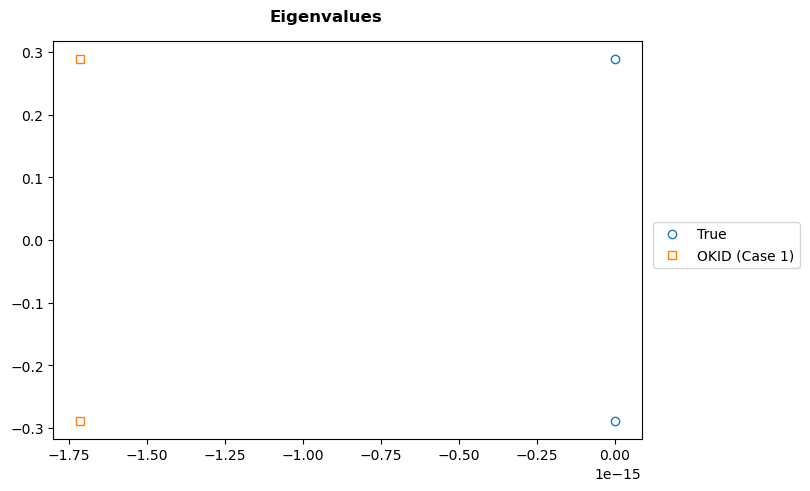

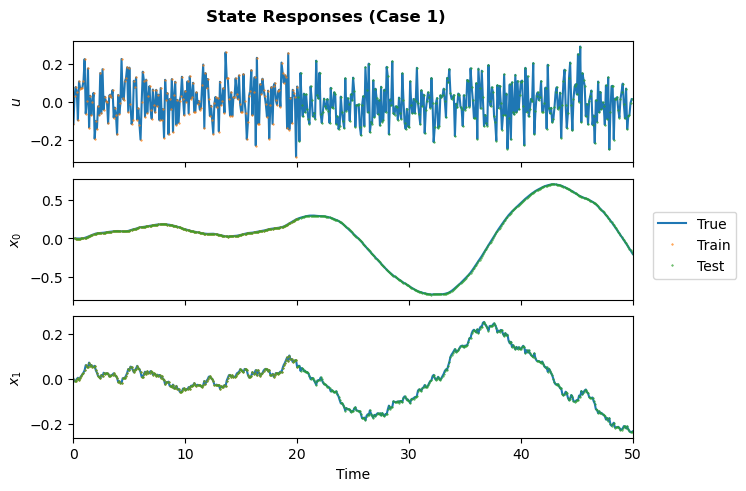

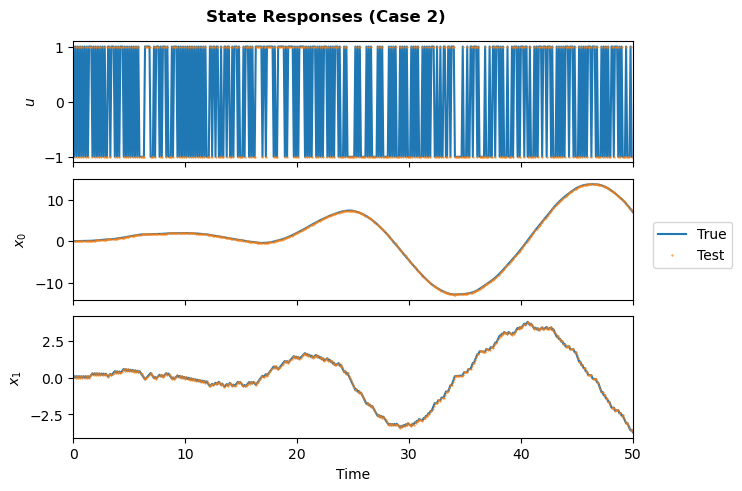

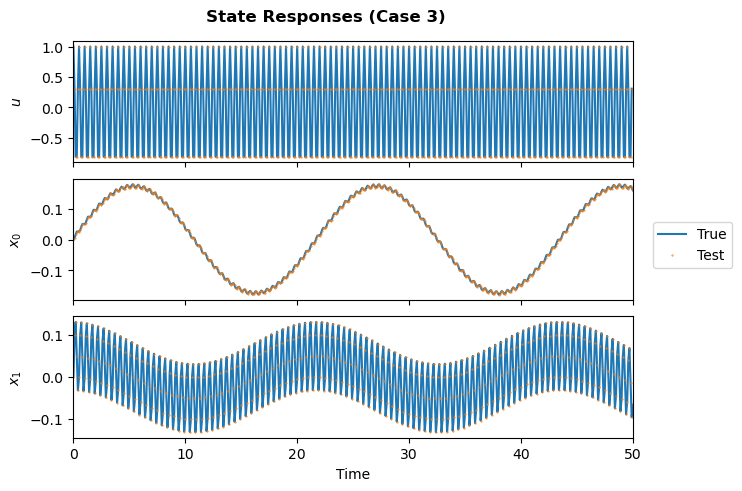

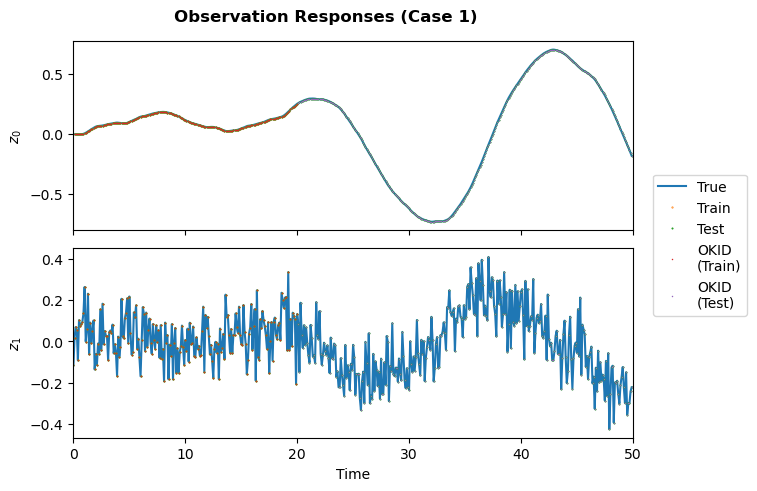

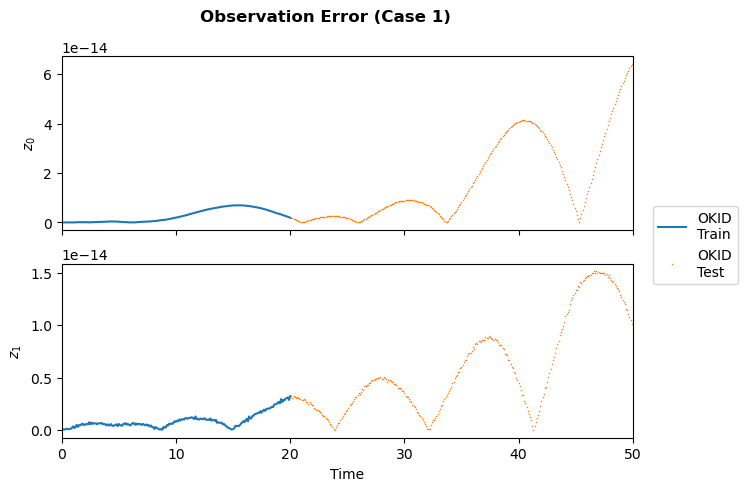

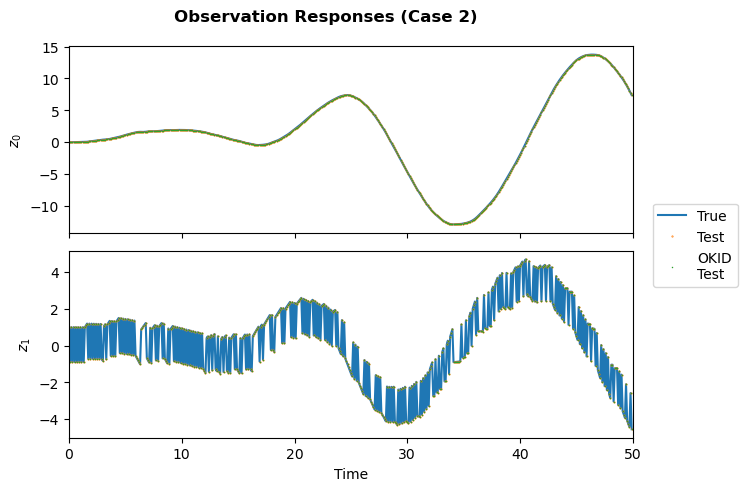

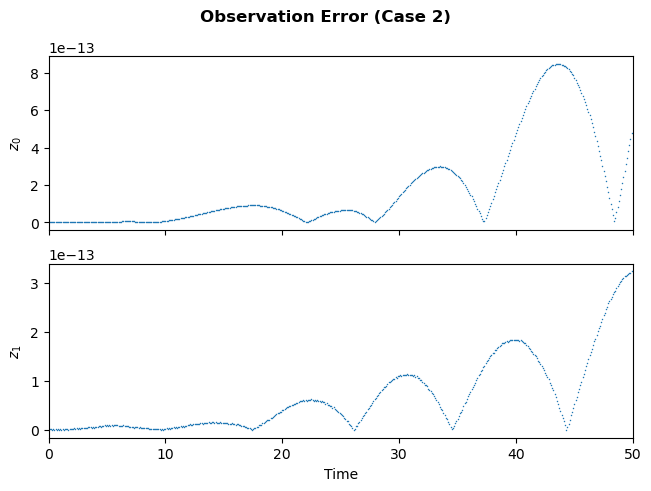

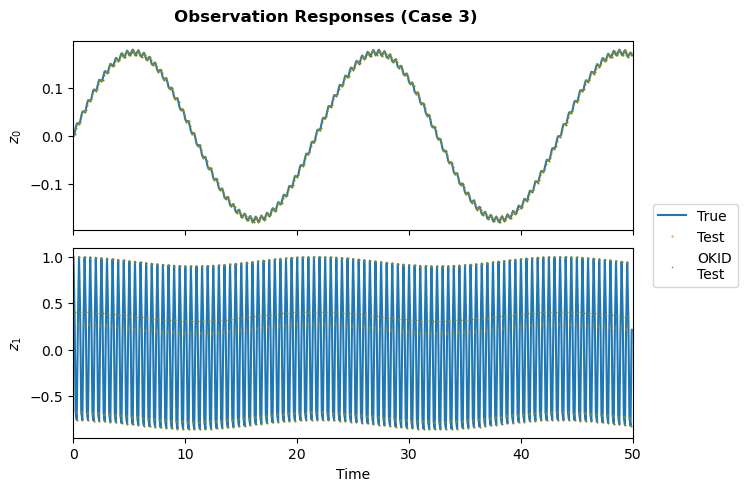

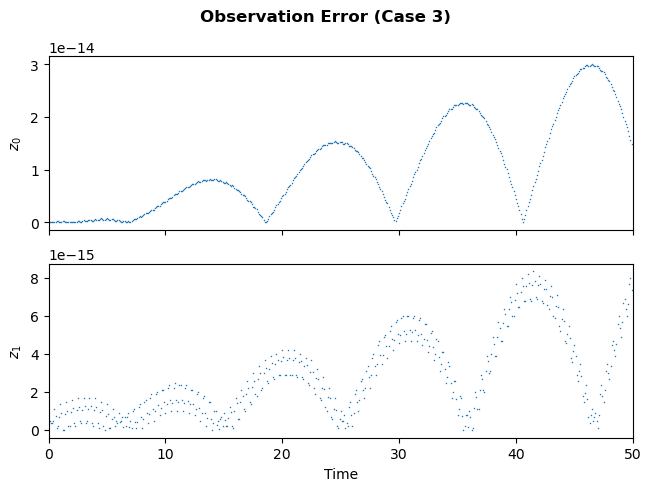

In [25]:
# Eigenvalue plots
fig, axs = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle("Eigenvalues", fontweight = "bold")

axs.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
axs.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
         "s", mfc = "None")

fig.legend(labels = ("True", "OKID (Case 1)", "OKID (Case 2)", "OKID (Case 3)"),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / "midterm_eigenvalues.pdf",
            dpi = 80, bbox_inches = "tight")

# # Singular value plots
# fig, axs = plt.subplots(constrained_layout = True) # type:figure.Figure
# fig.suptitle("Singular Values", fontweight = "bold")
#
# axs.plot(linspace(1, len(S[0]), len(S[0])), S[0], "o", mfc = "None")
# axs.plot(linspace(1, len(S_era[0]), len(S_era[0])), S_era[0], "o", mfc = "None")
# axs.plot(linspace(1, len(S_era[1]), len(S_era[1])), S_era[1], "s", mfc = "None")
# axs.plot(linspace(1, len(S_era[2]), len(S_era[2])), S_era[2], "D", mfc = "None")
#
# fig.legend(labels = ("True", "OKID (Case 1)", "OKID (Case 2)", "OKID (Case 3)"),
#            bbox_to_anchor = (1.25, 0.65))
# fig.savefig(figs_dir / "midterm_eigenvalues.pdf",
#             dpi = 80, bbox_inches = "tight")

# Response plots
ms = 0.5
for i in range(cases):
    fig, axs = plt.subplots(1 + n, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"State Responses (Case {i + 1})",
                 fontweight = "bold")

    if i == 0:
        axs[i].plot(t_sim[:-1], U_sim[i, 0])
        axs[i].plot(t_train, U_train[0],
                    "o", ms = ms, mfc = "None")
        axs[i].plot(t_test[train_cutoff:-1], U_test[i, 0, train_cutoff:],
                    "o", ms = ms, mfc = "None")
        plt.setp(axs[i], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_train, X_train[j],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test, X_test[i, j],
                            "o", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Train", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        axs[0].plot(t_sim[:-1], U_sim[i, 0])
        axs[0].plot(t_test[:-1], U_test[i, 0],
                    "o", ms = ms, mfc = "None")
        plt.setp(axs[0], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_test, X_test[i, j],
                            "o", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ("True", "Test"),
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_states_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")

# Observation plots
for i in range(cases):
    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"Observation Responses (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_test[i, j],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[j],
                        "*", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[i, j, train_cutoff:],
                        "*", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Train", "Test",
                             "OKID\n(Train)", "OKID\n(Test)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[i, j],
                        "*", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Test", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_obs_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")

    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"Observation Error (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[j] - Z_train[j]))
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[i, j, train_cutoff:] - Z_test[i, j, train_cutoff:]),
                        "*", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[i, j] - Z_test[i, j]),
                        "*", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
    fig.savefig(figs_dir / f"midterm_obs-error_case{i + 1}.pdf",
                dpi = 80, bbox_inches = "tight")